In [1]:
!pip install tensorflow pillow matplotlib scikit-learn opencv-python

2026-01-12 10:22:08.795093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0
✓ Downloaded cats/img_1.jpg
✓ Downloaded cats/img_2.jpg
✓ Downloaded cats/img_3.jpg
✓ Downloaded dogs/img_1.jpg
✓ Downloaded dogs/img_2.jpg
✓ Downloaded dogs/img_3.jpg
✓ Downloaded horses/img_1.jpg
✗ Failed to download horses/img_2.jpg
✗ Failed to download horses/img_3.jpg
Cats: 3 images
Dogs: 3 images
Horses: 1 images


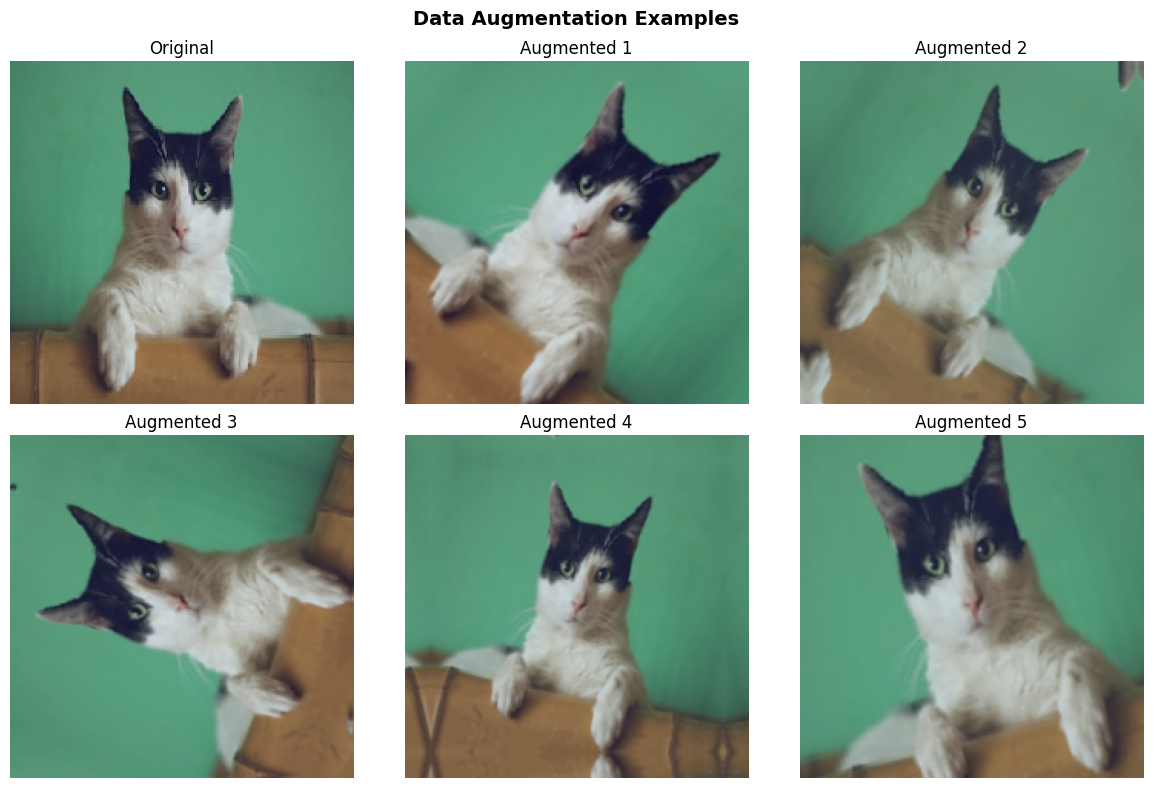


Loading images from: dataset
Classes found: ['cats', 'dogs', 'horses']

✓ Loaded 7 images
✓ Image shape: (7, 224, 224, 3)
✓ Labels shape: (7,)


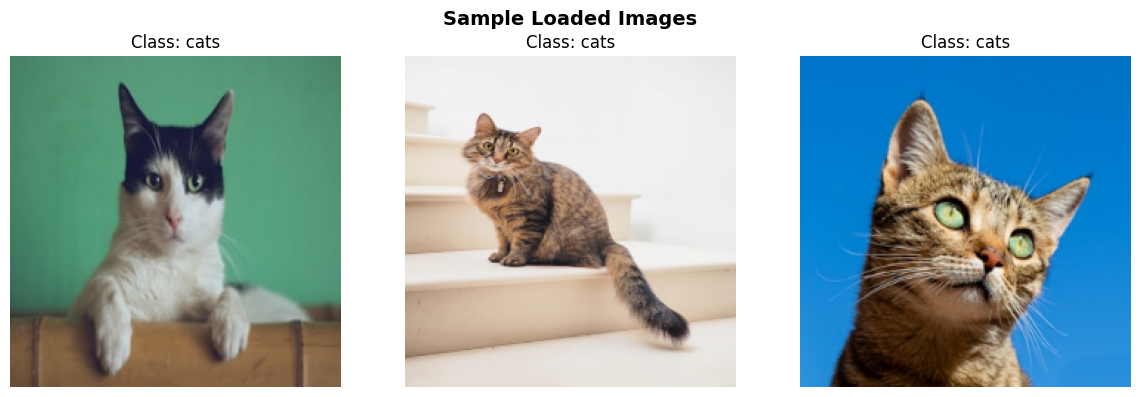

94765736/94765736 [==============================] - 3s 0us/step

✓ Model built successfully!

Model Summary:
Model: "resnet50_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total p

/Users/harikrishnan/Documents/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/harikrishnan/Documents/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/harikrishnan/Documents/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Precision: 0.1837
Recall:    0.4286
F1-Score:  0.2571
              precision    recall  f1-score   support

        cats       0.00      0.00      0.00         3
        dogs       0.43      1.00      0.60         3
      horses       0.00      0.00      0.00         1

    accuracy                           0.43         7
   macro avg       0.14      0.33      0.20         7
weighted avg       0.18      0.43      0.26         7



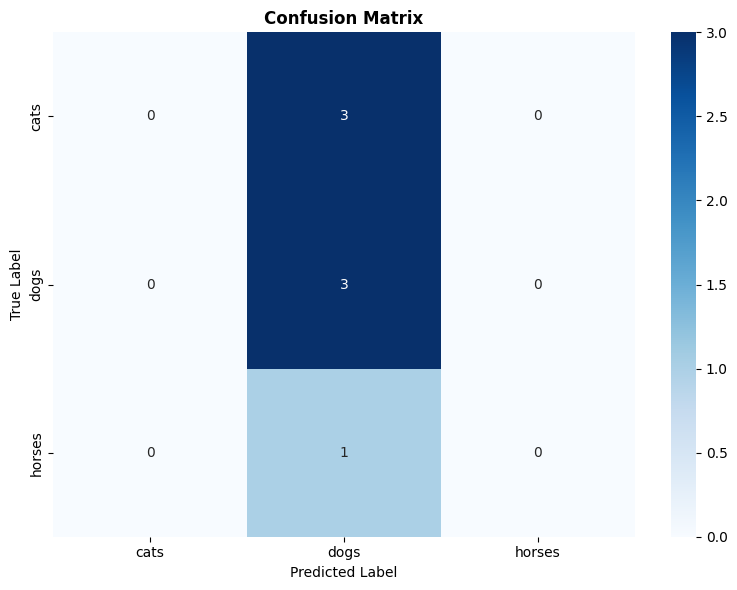

Found 7 images belonging to 3 classes.
Found 0 images belonging to 3 classes.

✓ Data generators created!

Training samples: 7
Validation samples: 0
Classes: ['cats', 'dogs', 'horses']

Generating augmented samples...


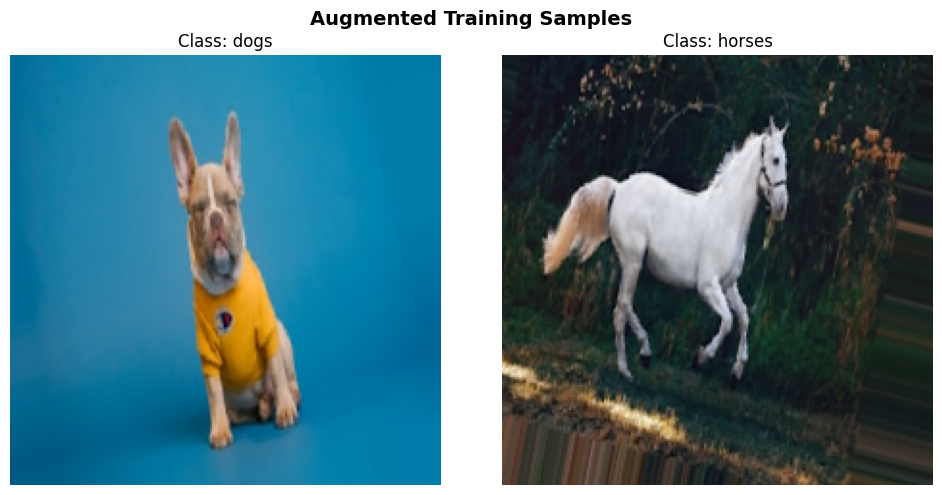

In [2]:
# IMAGE CLASSIFICATION - 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import cv2
import os
import urllib.request
import zipfile


print(f"TensorFlow version: {tf.__version__}")

# ============================================================================
# SETUP: Create Sample Dataset
# ============================================================================


# Create directory structure
os.makedirs('dataset/cats', exist_ok=True)
os.makedirs('dataset/dogs', exist_ok=True)
os.makedirs('dataset/horses', exist_ok=True)

# Function to download sample images
def download_sample_images():
    # Sample image URLs (public domain)
    sample_images = {
        'cats': [
            'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=300',
            'https://images.unsplash.com/photo-1495360010541-f48722b34f7d?w=300',
            'https://images.unsplash.com/photo-1574158622682-e40e69881006?w=300',
        ],
        'dogs': [
            'https://images.unsplash.com/photo-1517849845537-4d257902454a?w=300',
            'https://images.unsplash.com/photo-1529429617124-95b109e86bb8?w=300',
            'https://images.unsplash.com/photo-1583511655857-d19b40a7a54e?w=300',
        ],
        'horses': [
            'https://images.unsplash.com/photo-1553284965-83fd3e82fa5a?w=300',
            'https://images.unsplash.com/photo-1551563991-34e34d17ef18?w=300',
            'https://images.unsplash.com/photo-1534330980065-e4c7c5bb4b03?w=300',
        ]
    }
    
    for category, urls in sample_images.items():
        for i, url in enumerate(urls, 1):
            filepath = f'dataset/{category}/img_{i}.jpg'
            if not os.path.exists(filepath):
                try:
                    urllib.request.urlretrieve(url, filepath)
                    print(f"✓ Downloaded {category}/img_{i}.jpg")
                except:
                    print(f"✗ Failed to download {category}/img_{i}.jpg")

download_sample_images()


print(f"Cats: {len(os.listdir('dataset/cats'))} images")
print(f"Dogs: {len(os.listdir('dataset/dogs'))} images")
print(f"Horses: {len(os.listdir('dataset/horses'))} images")

# ============================================================================
# QUESTION 1: Custom Data Augmentation Pipeline
# ============================================================================


# Define augmentation layers
augmentation_model = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="augmentation")

# Test on one image
test_img_path = 'dataset/cats/img_1.jpg'
if os.path.exists(test_img_path):
    img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    # Apply augmentation multiple times
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    # Original
    axes[0].imshow(img_array[0].numpy().astype("uint8"))
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Augmented versions
    for i in range(1, 6):
        augmented = augmentation_model(img_array, training=True)
        axes[i].imshow(augmented[0].numpy().astype("uint8"))
        axes[i].set_title(f"Augmented {i}")
        axes[i].axis('off')
    
    plt.suptitle("Data Augmentation Examples", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ============================================================================
# QUESTION 2: Load and Preprocess Images Manually (No Generator)
# ============================================================================


def load_images_from_directory(directory, target_size=(224, 224)):
    """
    Load images from directory structure and preprocess manually
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    
    print(f"\nLoading images from: {directory}")
    print(f"Classes found: {class_names}")
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        
        if not os.path.isdir(class_path):
            continue
        
        for img_file in os.listdir(class_path):
            if img_file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_file)
                
                # Load image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Resize
                img = cv2.resize(img, target_size)
                
                # Normalize
                img = img / 255.0
                
                images.append(img)
                labels.append(class_idx)
    
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"\n✓ Loaded {len(images)} images")
    print(f"✓ Image shape: {images.shape}")
    print(f"✓ Labels shape: {labels.shape}")
    
    return images, labels, class_names

# Load dataset
X, y, class_names = load_images_from_directory('dataset')

# Display sample
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axes[i].imshow(X[i])
    axes[i].set_title(f"Class: {class_names[y[i]]}")
    axes[i].axis('off')
plt.suptitle("Sample Loaded Images", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# ============================================================================
# QUESTION 3: Pretrained ResNet for 3-Class Classification
# ============================================================================


# Load pretrained ResNet50
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
base_model.trainable = False

# Build custom model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes
], name="resnet50_custom")

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()



# ============================================================================
# QUESTION 4: Calculate Precision, Recall, F1-Score
# ============================================================================

# Make predictions (using our manually loaded data)
print("\nMaking predictions...")
predictions = model.predict(X, verbose=0)
y_pred = np.argmax(predictions, axis=1)

# Calculate metrics
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')


print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Detailed classification report

print(classification_report(y, y_pred, target_names=class_names))

# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# ============================================================================
# QUESTION 5: ImageDataGenerator for Multiclass Dataset
# ============================================================================


# Create ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    'dataset',
    target_size=(224, 224),
    batch_size=2,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    'dataset',
    target_size=(224, 224),
    batch_size=2,
    class_mode='categorical',
    subset='validation'
)

print("\n✓ Data generators created!")
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Classes: {list(train_generator.class_indices.keys())}")

# Visualize augmented batch
print("\nGenerating augmented samples...")
sample_batch, sample_labels = next(train_generator)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    axes[i].imshow(sample_batch[i])
    class_idx = np.argmax(sample_labels[i])
    axes[i].set_title(f"Class: {list(train_generator.class_indices.keys())[class_idx]}")
    axes[i].axis('off')
plt.suptitle("Augmented Training Samples", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


